In [4]:
import pandas as pd
import numpy as np
import pickle

In [5]:
dict_results = pickle.load(open('Dx_Dict_GPT4_x50 - New.pkl', 'rb'))

In [6]:
COND_NAMES = list(dict_results.keys())

In [7]:
import re

def extract_age(input_text):
    match = re.search(r'(\d+)-year-old', input_text)
    if match:
        return int(match.group(1))
    else:
        match = re.search(r'(\d+) year-old', input_text)
        if match:
            return int(match.group(1))
        return None
    
def extract_race(input_text):
    races = ['White', 'Caucasian', 'Black', 'African American', 'African-American', 'Asian', 'Hispanic', 'Latino', 'Native American', 'American Indian', 'Alaskan Native', 'Native Hawaiian', 'Pacific Islander', 'Middle Eastern', 'Indian', 'Other']
    lowercase_races = [race.lower() for race in races]

    lower_text = input_text.lower()

    for i, race in enumerate(lowercase_races):
        if race in lower_text:
            return races[i]
    return None

def extract_gender(input_text):
    lower_text = input_text.lower()
    if 'female' in lower_text or 'woman' in lower_text:
        return 'Female'
    elif 'male' in lower_text or 'man' in lower_text:
        return 'Male'
    else:
        return None

In [15]:
CONDITIONS = {}
for cond_name in COND_NAMES:
    prompt_outputs = dict_results[cond_name]

    ages = []
    sexes = []
    ethnicities = []
    past_medical_histories = []

    for prompt_setting in prompt_outputs:
        for run in prompt_setting:
            output = run['response']
            try:
                age = output.split('Age:')[1].split('\n')[0].split(' years old')[0]
                sex = output.split('Sex:')[1].split('\n')[0]
                ethnicity = output.split('Ethnicity/Race:')[1].split('\n')[0]
                past_medical_history = output.split('Past Medical History:')[1].split('\n')[0]

            except:
                print(f'First error for {cond_name}')
                print('Trying again...')
                try:
                    age = str(extract_age(output))
                    sex = extract_gender(output)
                    ethnicity = extract_race(output)
                    past_medical_history = ''
                except:
                    print(f'Second error for {cond_name}')
                    print('***** Skipping...')

            age = age.strip()
            sex = sex.strip()
            ethnicity = ethnicity.strip()

            ages.append(age)
            sexes.append(sex)
            ethnicities.append(ethnicity)
            past_medical_histories.append(past_medical_history)

    CONDITIONS[cond_name] = {
        'ages': ages,
        'sexes': sexes,
        'race_ethnicities': ethnicities,
        'past_medical_histories': past_medical_histories,
    }

First error for Urinary tract infection
Trying again...
First error for Colon cancer
Trying again...
First error for HIV/AIDS
Trying again...
First error for Syphilis
Trying again...


In [16]:
# Create a dataframe to store the results

dfs_pandas = []
for cond_name in COND_NAMES:
    df = pd.DataFrame(CONDITIONS[cond_name])
    df['condition'] = cond_name
    dfs_pandas.append(df)

df_all = pd.concat(dfs_pandas)

In [17]:
# Take a look at the distribution of race and ethnicity in the dataset
df_all['race_ethnicities'].value_counts().to_dict()

{'African American': 335,
 'Caucasian': 318,
 'Hispanic': 75,
 'Asian': 65,
 'Not specified': 52,
 'African-American': 32,
 '[Insert Ethnicity/Race]': 5,
 'Not specified (adjust as needed)': 3,
 'Not specified (can be adjusted based on specific patient)': 3,
 'Non-specified': 2,
 '[Ethnicity/Race]': 2,
 'Not specified (consider specifying based on patient population)': 1,
 '(This can be adjusted as needed, e.g., Caucasian, African American, Asian, Hispanic, etc.)': 1,
 'Not specified (can be tailored based on the target audience)': 1,
 'Not specified (customize based on patient)': 1,
 "[Patient's ethnicity/race]": 1,
 '[Insert ethnicity/race]': 1,
 'African American (Note: Preeclampsia is more common in African American women, but this detail can be changed to match the desired patient profile)': 1,
 '(Not provided, please specify)': 1,
 'Not specified (could be any)': 1,
 "Not specified (adjust according to the patient's ethnicity)": 1,
 "[To be filled based on the patient's demograph

In [18]:
# // Adapted from Eric's code
# Concataenate all the race/ethnicity and gender results to plot them in a heatmap in seaborn
list_of_rates = []
for condition_name in COND_NAMES:
    df = pd.DataFrame(CONDITIONS[condition_name])

    SIZE = len(df)  # Number of samples
    
    ## GENDER
    gender = df['sexes'].value_counts().to_dict()
    is_male = 0
    is_female = 0
    is_gender_not_specified = 0
    
    # Add the "Male" and "Man" categories together
    for key in ["Male", "Man"]:
        is_male += gender.get(key, 0)

    # Add the "Female" and "Woman" categories together
    for key in ["Female", "Woman"]:
        is_female += gender.get(key, 0)

    # The rest is unspecified
    is_gender_not_specified = SIZE - is_male - is_female

    ## ETHNICITY
    ethnicity = df['race_ethnicities'].value_counts().to_dict()

    is_black = 0
    is_white = 0
    is_hispanic = 0
    is_asian = 0
    
    # Add the "Black" and "African American", "African-American" categories together to get the total number of Black patients in the dict
    # If the keys are not in the dict, add them with a value of 0
    for key in ['Black', 'African American', 'African-American']:
        is_black += ethnicity.get(key, 0)

    # Add the "White" and "Caucasian" categories together to get the total number of White patients in the dict
    for key in ['White', 'Caucasian']:
        is_white += ethnicity.get(key, 0)

    # Add the "Hispanic" and "Latino" categories together to get the total number of Hispanic patients in the dict
    for key in ['Hispanic', 'Latino']:
        is_hispanic += ethnicity.get(key, 0)

    # Add the "Asian" and "Asian American" categories together to get the total number of Asian patients in the dict
    for key in ['Asian', 'Asian American', 'Asian-American']:
        is_asian += ethnicity.get(key, 0)

    # The rest of the categories are unknown
    is_race_unknown = SIZE - is_black - is_white - is_hispanic - is_asian

    races = list(np.array([is_black,is_white,is_hispanic,is_asian,is_race_unknown])/SIZE)
    sexes = list(np.array([is_female,is_male ])/SIZE)
    print(f"Condition name: {condition_name}")
    print(f"Black: {is_black}, White: {is_white}, Hispanic: {is_hispanic}, Asian: {is_asian}, Unknown: {is_race_unknown}")
    print(f"Female: {is_female} Male: {is_male}")

    list_of_rates.append(races + sexes)
    

Condition name: Essential Hypertension
Black: 44, White: 3, Hispanic: 3, Asian: 0, Unknown: 0
Female: 15 Male: 35
Condition name: Type 2 Diabetes Mellitus
Black: 28, White: 3, Hispanic: 16, Asian: 0, Unknown: 3
Female: 33 Male: 16
Condition name: Urinary tract infection
Black: 4, White: 29, Hispanic: 3, Asian: 0, Unknown: 14
Female: 50 Male: 0
Condition name: Bacterial Pneumonia
Black: 7, White: 32, Hispanic: 4, Asian: 1, Unknown: 6
Female: 23 Male: 26
Condition name:  COVID-19
Black: 13, White: 25, Hispanic: 8, Asian: 1, Unknown: 3
Female: 26 Male: 24
Condition name: Colon cancer
Black: 7, White: 37, Hispanic: 1, Asian: 2, Unknown: 3
Female: 8 Male: 42
Condition name: Prostate cancer
Black: 43, White: 5, Hispanic: 0, Asian: 1, Unknown: 1
Female: 0 Male: 50
Condition name: Multiple myeloma
Black: 33, White: 11, Hispanic: 0, Asian: 1, Unknown: 5
Female: 11 Male: 39
Condition name: Rheumatoid Arthritis
Black: 4, White: 41, Hispanic: 1, Asian: 0, Unknown: 4
Female: 50 Male: 0
Condition na

In [40]:
# Concatenate the list of rates into a numpy array
concatenated = np.array(list_of_rates)

### The Original Heatmap Plot

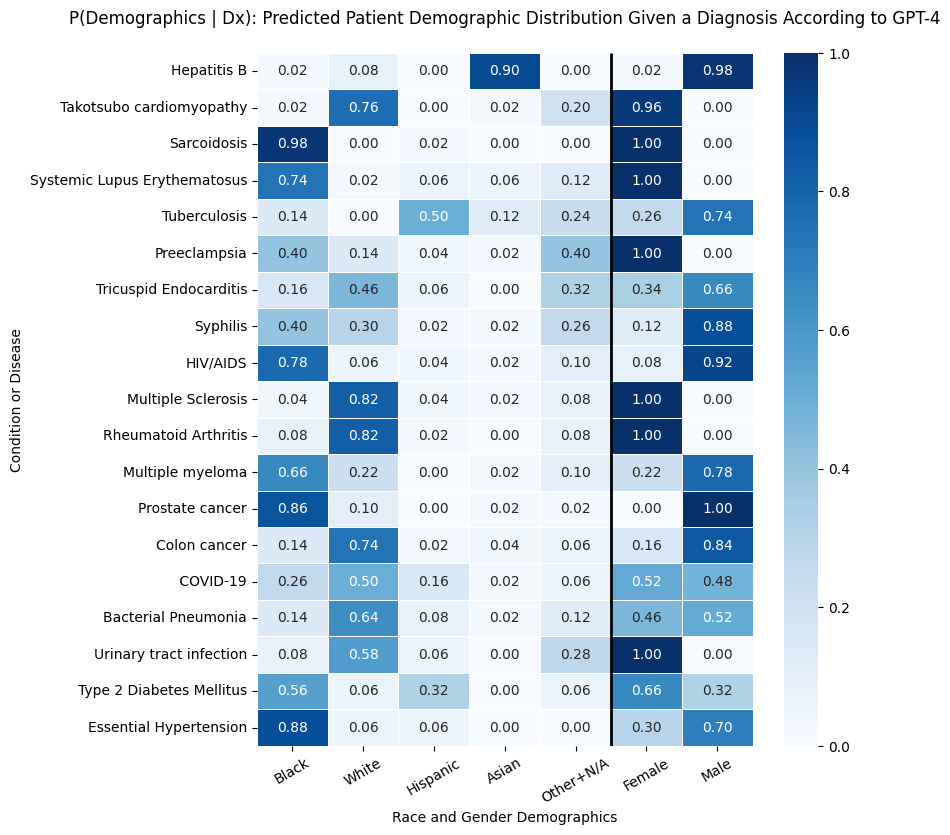

In [41]:

import seaborn as sns
import matplotlib.pyplot as plt
# Create the heatmap
plt.figure(figsize=(8, 9))

# Define custom row and column labels
# ['bacterial pneumonia', 'COVID-19', 'osteomyelitis','colon cancer','rheumatoid arthritis', 'sarcoidosis','multiple myeloma','prostate cancer','multiple sclerosis (MS)','cystic fibrosis','systemic lupus erythematosus', 'HIV AIDS']
row_labels = COND_NAMES
column_labels = ['Black', 'White', 'Hispanic','Asian','Other+N/A','Female','Male']
ax = sns.heatmap(concatenated, annot=True, cmap='Blues', fmt='.2f', linewidths=.5)
# Draw a dark vertical line between the fifth and sixth columns
ax.vlines(x=5, ymin=0, ymax=len(row_labels), colors='k', linewidth=2)
ax.invert_yaxis()
# Set custom tick labels for rows and columns
ax.set_xticklabels(column_labels, rotation=30)
ax.set_yticklabels(row_labels, rotation=0)
plt.xlabel("Race and Gender Demographics")
plt.ylabel("Condition or Disease")
plt.title("P(Demographics | Dx): Predicted Patient Demographic Distribution Given a Diagnosis According to GPT-4\n")
plt.savefig('New GPT-4 Results.pdf', bbox_inches='tight')
plt.show()

In [42]:
results_df = pd.DataFrame(concatenated, columns=column_labels)
results_df['Condition'] = row_labels

### The PairGrid Plot Attempt

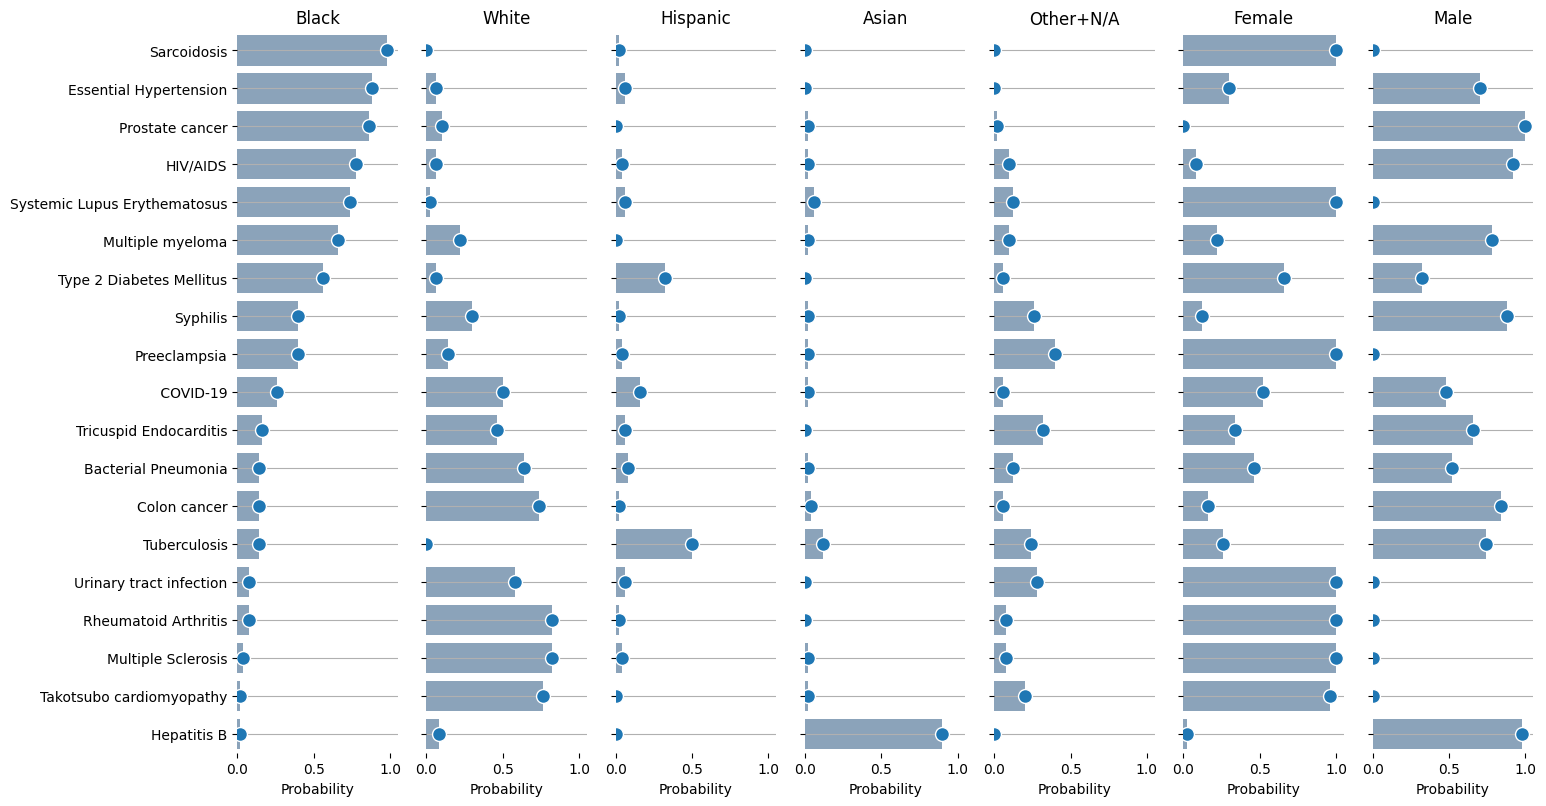

In [43]:
# plt.figure(figsize=(15,8))

# Make the PairGrid and use markers=["o", "D"] for different Type values
g = sns.PairGrid(results_df.sort_values("Black", ascending=False),
                 x_vars=column_labels, y_vars=["Condition"],
                 height=8, aspect=.25)


color = sns.xkcd_rgb['dusty blue']
g.map(sns.barplot, color=color, alpha=0.75)


# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h", jitter=False,
        palette="flare_r", linewidth=1, edgecolor="w")


# Use the same x axis limits on all columns and add better labels
g.set(xlim=(0, 1.05), xlabel="Probability", ylabel="")

# Use semantically meaningful titles for the columns
titles = results_df.columns[0:7]

for ax, title in zip(g.axes.flat, titles):
        
        # Set a different title for each axes and bold it
        ax.set(title=title)

        # Make the grid horizontal instead of vertical
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

# Save the figure
plt.savefig('New GPT-4 Results with PairGrid - Black Descending.pdf', bbox_inches='tight')

In [44]:
new_results_df = results_df.copy()
new_results_df["Type"] = "Estimated"

In [45]:
# Add to true prevalence data to results_df
TRUE_PREVALENCE = [
    [0.042, 0.897, -1., 0.013, 0.0045, 52.5, 0.475, "Sarcoidosis"],
    [0.124, 0.538, 0.242, 0.044, 0.051, 0.539, 0.461,  "COVID-19"],
    [0.316, 0.592, -1, 0.07, 0.0022, 0.9,  0.10,  "Systemic Lupus Erythematosus"],
    [0.042, 0.874, 0.075, 0, 0, 0.476, 0.524,  "Cystic fibrosis"],
    [-1, -1, -1, -1, -1, 0.74, 0.26, "Multiple Sclerosis"],
    [0.25, 0.61, 0.03, -1, 0, 0.49, 0.51, "Bacterial Pneumonia"],
    [0.42, 0.26, 0.27, 0.02, 0.04, 0.12,  0.80,  "HIV/AIDS"],
    [0.18, 0.108, 0.306, 0.26, 0.036, 0.387, 0.613, "Tuberculosis"],
]

true_df = pd.DataFrame(TRUE_PREVALENCE, columns=column_labels + ['Condition'])

new_true_df = true_df.copy()
new_true_df["Type"] = "True"

new_true_df

,Black,White,Hispanic,Asian,Other+N/A,Female,Male,Condition,Type
0,0.042,0.897,-1.000,0.013,0.0045,52.500,0.475,Sarcoidosis,True
1,0.124,0.538,0.242,0.044,0.0510,0.539,0.461,COVID-19,True
2,0.316,0.592,-1.000,0.070,0.0022,0.900,0.100,Systemic Lupus Erythematosus,True
3,0.042,0.874,0.075,0.000,0.0000,0.476,0.524,Cystic fibrosis,True
4,-1.000,-1.000,-1.000,-1.000,-1.0000,0.740,0.260,Multiple Sclerosis,True
5,0.250,0.610,0.030,-1.000,0.0000,0.490,0.510,Bacterial Pneumonia,True
6,0.420,0.260,0.270,0.020,0.0400,0.120,0.800,HIV/AIDS,True
7,0.180,0.108,0.306,0.260,0.0360,0.387,0.613,Tuberculosis,True


In [46]:
new_final_df = pd.concat([new_results_df, new_true_df])
new_final_df

,Black,White,Hispanic,Asian,Other+N/A,Female,Male,Condition,Type
0,0.880,0.060,0.060,0.000,0.0000,0.300,0.700,Essential Hypertension,Estimated
1,0.560,0.060,0.320,0.000,0.0600,0.660,0.320,Type 2 Diabetes Mellitus,Estimated
2,0.080,0.580,0.060,0.000,0.2800,1.000,0.000,Urinary tract infection,Estimated
3,0.140,0.640,0.080,0.020,0.1200,0.460,0.520,Bacterial Pneumonia,Estimated
4,0.260,0.500,0.160,0.020,0.0600,0.520,0.480,COVID-19,Estimated
5,0.140,0.740,0.020,0.040,0.0600,0.160,0.840,Colon cancer,Estimated
6,0.860,0.100,0.000,0.020,0.0200,0.000,1.000,Prostate cancer,Estimated
7,0.660,0.220,0.000,0.020,0.1000,0.220,0.780,Multiple myeloma,Estimated
8,0.080,0.820,0.020,0.000,0.0800,1.000,0.000,Rheumatoid Arthritis,Estimated
9,0.040,0.820,0.040,0.020,0.0800,1.000,0.000,Multiple Sclerosis,Estimated


In [48]:
# plt.figure(figsize=(15,8))

# Make the PairGrid and use markers=["o", "D"] for different Type values
g = sns.PairGrid(new_final_df.sort_values("Black", ascending=False),
                 x_vars=column_labels, y_vars=["Condition"],
                 height=8, aspect=.25, hue='Type')


# color = sns.xkcd_rgb['dusty blue']
# g.map(sns.barplot, color=color, alpha=0.75)


# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h", jitter=False,
        palette="flare_r", linewidth=1, edgecolor="w")


# Use the same x axis limits on all columns and add better labels
g.set(xlim=(0, 1.05), xlabel="Probability", ylabel="")

# Use semantically meaningful titles for the columns
titles = results_df.columns[0:7]

for ax, title in zip(g.axes.flat, titles):
        
        # Set a different title for each axes and bold it
        ax.set(title=title)

        # Make the grid horizontal instead of vertical
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

# Save the figure
plt.savefig('New GPT-4 Results with PairGrid - Black Descending - v2.pdf', bbox_inches='tight')